# Body Fat Percentage

<img src = "bodyfat-visual-reference-men.gif" width="800">

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedKFold , GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import RobustScaler , MinMaxScaler , StandardScaler , QuantileTransformer , PowerTransformer , OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import shapiro , stats

import warnings
warnings.filterwarnings(action = "ignore")
plt.rcParams["figure.figsize"] = (12,8)
pd.set_option("display.max_columns" , None)

# Importing Dataset

In [2]:
data = pd.read_csv("bodyfat.csv")
df = data.copy()
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


# Variables' Description
* Density determined from underwater weighing
* Percent body fat from Siri's (1956) equation
* Age (years)
* Weight (lbs)
* Height (inches)
* Neck circumference (cm)
* Chest circumference (cm)
* Abdomen 2 circumference (cm)
* Hip circumference (cm)
* Thigh circumference (cm)
* Knee circumference (cm)
* Ankle circumference (cm)
* Biceps (extended) circumference (cm)
* Forearm circumference (cm)
* Wrist circumference (cm)

# Checking if there are null values in the dataset or not

In [3]:
df.isnull().sum()

Density    0
BodyFat    0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64

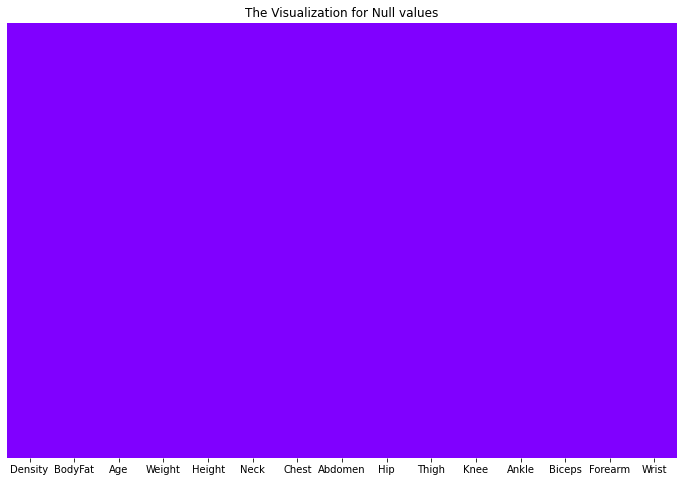

In [4]:
sns.heatmap(data = df.isnull() , cmap = "rainbow" , cbar = False , yticklabels=False)
plt.title("The Visualization for Null values")
plt.show()

# Checking if there is duplicated values in the dataset

In [5]:
print("There are {} duplicates in the dataset".format(df.duplicated().sum()))

There are 0 duplicates in the dataset


# Checking outliers with the help of the boxplot

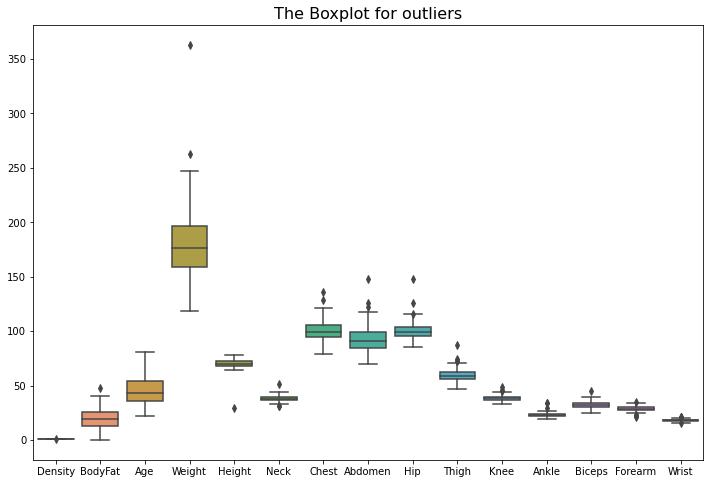

In [6]:
sns.boxplot(data = df)
plt.title("The Boxplot for outliers" , fontsize = 16)
plt.show()

# There are aoutliers in the dataset so I will apply Robustscaler

# Splitting the dataset to X and y

In [7]:
X = df.drop(columns = ["BodyFat"])
y = df["BodyFat"]

# Splitting the dataset to train and test 

In [8]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

# Automate score, metrics, cross validation with the help of the functions

In [9]:
def score_func(model_name) : 
    train_score = model_name.score(X_train , y_train)
    test_score = model_name.score(X_test , y_test)
    
    print("The train score is {:.2%}".format(train_score))
    print("The test score is {:.2%}".format(test_score))

In [10]:
def metrics_func(model_name) : 
    y_pred = model_name.predict(X_test)
    r2 =r2_score(y_test , y_pred)
    mean_abs = mean_absolute_error(y_test , y_pred)
    mean_sqr = mean_squared_error(y_test , y_pred)
    mean_abs_pr = mean_absolute_percentage_error(y_test , y_pred)
    
    print("The r2 score is {:.2%}".format(r2))
    print("The mean absolute erros is {:.2f}".format(mean_abs))
    print("The mean squared error is {:.2f}".format(mean_sqr))
    print("THe mean absolute percentage error is {:.2f}".format(mean_abs_pr))

In [11]:
def adjust_rsquared(model_name) : 
    N = X.shape[0]
    p = X.shape[1]/2
    y_pred = model_name.predict(X_test)
    r2 = r2_score(y_test , y_pred)
    first = (1-r2)*(N-1)
    second = N-p-1
    result = 1-(first/second)
    return np.round(result,2)

In [12]:
def cross_func(model_name) : 
    cr = cross_val_score(estimator=model_name , X = X_train , y = y_train , scoring="r2" , cv = 10 , n_jobs=-1)
    max_power = np.argmax(cr)
    min_power = np.argmin(cr)
    mean_power = np.mean(cr)
    std = np.std(cr)
    
    print("The maxiumum score for this model can be {:.2%}".format(cr[max_power]))
    print("The minumum score for this model can be {:.2%}".format(cr[min_power]))
    print("The average cross validation is {:.2%}".format(mean_power))
    print("The standart devidation of the cross validation is {}".format(std))

# Creating pipeline for Linear Regression

In [13]:
model_linear = make_pipeline(RobustScaler() , SequentialFeatureSelector(estimator=LinearRegression() , 
                                                                        cv = RepeatedKFold(random_state=42) , scoring="r2" , n_jobs=-1) , 
                             LinearRegression())
model_linear.fit(X_train , y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=42),
                                           estimator=LinearRegression(),
                                           n_jobs=-1, scoring='r2')),
                ('linearregression', LinearRegression())])

# Tunining scaling methods for choosing the best one

In [14]:
parametrs = {"robustscaler" : [MinMaxScaler() , StandardScaler() , MinMaxScaler() , PowerTransformer() , QuantileTransformer()]}

In [15]:
model_linear_tuned = GridSearchCV(estimator=model_linear , param_grid=parametrs , scoring="r2" , n_jobs=-1 , cv = RepeatedKFold(random_state = 42) , verbose=1)
model_linear_tuned.fit(X_train , y_train)

Fitting 50 folds for each of 5 candidates, totalling 250 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('sequentialfeatureselector',
                                        SequentialFeatureSelector(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=42),
                                                                  estimator=LinearRegression(),
                                                                  n_jobs=-1,
                                                                  scoring='r2')),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'robustscaler': [MinMaxScaler(), StandardScaler(),
                                          MinMaxScaler(), PowerTransformer(),
                                          QuantileTransformer()]},
             scoring='r2', verbose

# Train and Test scores for Linear Regression

In [16]:
score_func(model_name=model_linear_tuned)

The train score is 97.39%
The test score is 99.52%


# Metrics for Linear Regression

In [17]:
metrics_func(model_name = model_linear_tuned)

The r2 score is 99.52%
The mean absolute erros is 0.40
The mean squared error is 0.22
THe mean absolute percentage error is 0.03


# Adjusted r squared for Linear Regression

In [18]:
adjust_rsquared(model_name=model_linear_tuned)

1.0

# Cross Validation for Linear Regression

In [19]:
cross_func(model_name=model_linear_tuned)

The maxiumum score for this model can be 99.85%
The minumum score for this model can be 81.58%
The average cross validation is 95.60%
The standart devidation of the cross validation is 0.0635325104240743


# Adaboost

In [20]:
model_ada = make_pipeline(SequentialFeatureSelector(estimator=AdaBoostRegressor() , scoring="r2" , 
                    cv = RepeatedKFold(random_state=42) , n_jobs=-1) , AdaBoostRegressor())
model_ada

Pipeline(steps=[('sequentialfeatureselector',
                 SequentialFeatureSelector(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=42),
                                           estimator=AdaBoostRegressor(),
                                           n_jobs=-1, scoring='r2')),
                ('adaboostregressor', AdaBoostRegressor())])

# Hyperparametr tuning for Adaboost

In [22]:
from xgboost import XGBRegressor
base_model = XGBRegressor()
parametrs = {"adaboostregressor__n_estimators" : [30,50,70,100,150,200] , "adaboostregressor__learning_rate" : [0.01,0.1,1],
            "adaboostregressor__loss" : ["linear" , "square" , "exponential"] , "adaboostregressor__base_estimator" : [base_model]} 

In [23]:
model_ada_tuned = RandomizedSearchCV(estimator=model_ada , param_distributions=parametrs , scoring="r2" , cv = 10 , verbose=1 , n_jobs=-1)
model_ada_tuned.fit(X_train , y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('sequentialfeatureselector',
                                              SequentialFeatureSelector(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=42),
                                                                        estimator=AdaBoostRegressor(),
                                                                        n_jobs=-1,
                                                                        scoring='r2')),
                                             ('adaboostregressor',
                                              AdaBoostRegressor())]),
                   n_jobs=-1,
                   param_distributions={'adaboostregressor__base_estimator': [XGBRegressor(base_s...
                                                                                           num_parallel_tree=None,
                                                                                           predictor=None,
  

# Choosen parametrs

In [24]:
model_ada_tuned.best_params_

{'adaboostregressor__n_estimators': 50,
 'adaboostregressor__loss': 'square',
 'adaboostregressor__learning_rate': 1,
 'adaboostregressor__base_estimator': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)}

# Train and Test scores for Adaboost

In [25]:
score_func(model_name=model_ada_tuned)

The train score is 99.92%
The test score is 98.88%


# Metrics for Adaboost 

In [26]:
metrics_func(model_name=model_ada_tuned)

The r2 score is 98.88%
The mean absolute erros is 0.52
The mean squared error is 0.52
THe mean absolute percentage error is 0.03


# Adjusted r squared for Linear Regression

In [27]:
adjust_rsquared(model_name=model_ada_tuned)

0.99

# Cross Validation for Linear Regression

In [28]:
cross_func(model_name=model_ada_tuned)

The maxiumum score for this model can be 99.88%
The minumum score for this model can be 83.53%
The average cross validation is 95.83%
The standart devidation of the cross validation is 0.051046239534477775


# Saving our model with pickle

In [29]:
import pickle
filename = "BodyFat"
pickle.dump(model_ada_tuned , open(filename , "wb"))

# Visualizing the distributions of the variables

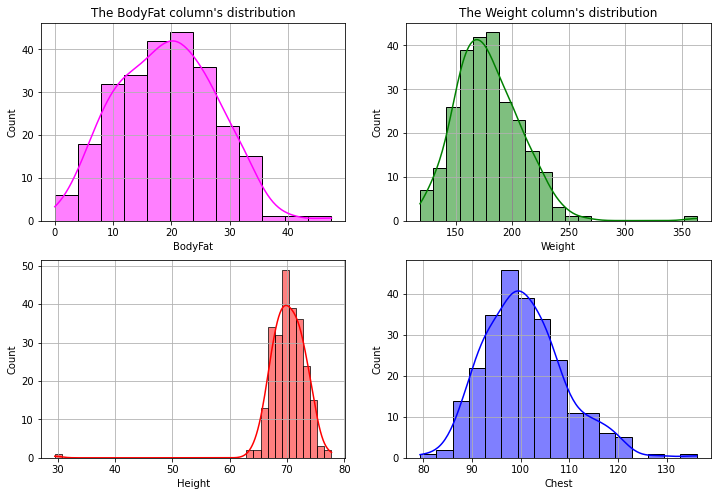

In [34]:
plt.subplot(2,2,1)
sns.histplot(data = df["BodyFat"] , kde = True , color="magenta")
plt.title("The BodyFat column's distribution" , fontsize = 12)
plt.grid()
plt.subplot(2,2,2)
sns.histplot(data = df["Weight"] , kde = True , color = "green")
plt.title("The Weight column's distribution" , fontsize = 12)
plt.grid()
plt.subplot(2,2,3)
sns.histplot(data = df["Height"] , kde = True , color = "red")
plt.grid()
plt.subplot(2,2,4)
sns.histplot(data = df["Chest"] , kde = True , color = "blue")
plt.grid()

# Visualizing the correlations

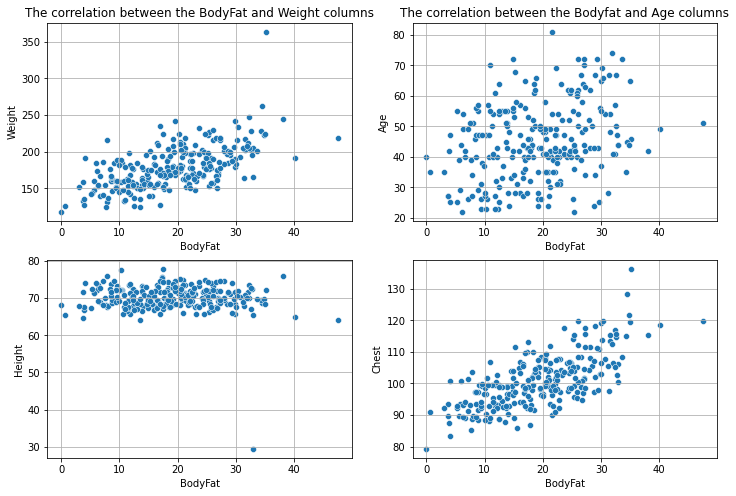

In [36]:
plt.subplot(2,2,1)
sns.scatterplot(data = df , x = "BodyFat" , y = "Weight")
plt.title("The correlation between the BodyFat and Weight columns" , fontsize = 12)
plt.grid()
plt.subplot(2,2,2)
sns.scatterplot(data = df , x = "BodyFat" , y = "Age")
plt.title("The correlation between the Bodyfat and Age columns" , fontsize = 12)
plt.grid()
plt.subplot(2,2,3)
sns.scatterplot(data = df , x = "BodyFat",  y = "Height")
plt.grid()
plt.subplot(2,2,4)
sns.scatterplot(data = df , x = "BodyFat" , y = "Chest")
plt.grid()